In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import numpy as np
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import sys
import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
from pprint import pprint
%matplotlib inline


sys.path.insert(0, '..')
from src.models.utils import FaceDataset

In [32]:
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
        ToTensorV2(),
    ])

In [53]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [54]:
def __init__(self, params):
    super(Net, self).__init__()
    
    C_in,H_in,W_in=params["input_shape"] 
    self.dropout_rate=params["drop_rate"] 
    self.num_fc1 = params["num_fc1"]
    
    mobile_v3 = timm.create_model('mobilenetv3_large_100', pretrained=False)
    
    in_features = mobile_v3.classifier.in_features
    
    mobile_v3.classifier = nn.Linear(in_features, self.num_fc1)
    
    self.backbone = nn.Sequential(
                    mobile_v3,
                    nn.BatchNorm1d(num_features=self.num_fc1),
                    nn.ReLU()
    )
    
    self.gender_head = nn.Sequential(
                            nn.Dropout(p=self.dropout_rate),
                            nn.Linear(self.num_fc1, 1),
                            nn.Sigmoid()
    )
    
    self.age_head = nn.Sequential(
                    nn.Linear(self.num_fc1, 1)
    )

In [55]:
def forward(self, x):
    x = self.backbone(x)  
    
    gender = self.gender_head(x)
    age = self.age_head(x)
    
    return age, gender

In [59]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,224,224),
        "drop_rate" : 0.2,
        "num_fc1" : 512,
    }

model = Net(params_model)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

device = torch.device("cuda")
model = model.to(device)

Let's use 4 GPUs!


In [60]:
checkpoint = torch.load('../models/exp_2020_12_09-09_45_03/best_checkpoints.bin')
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

In [61]:
class CustomFaceDataset(FaceDataset):
    def __getitem__(self, idx):
        path = self.df.iloc[idx]["file_name"]
        age = self.df.iloc[idx]["age"].astype(np.float32)
        gender = self.df.iloc[idx]["gender"].astype(np.float32)
        
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')
        img /= 255.0
        
        label_list = [age, gender]
        label_tensor = torch.tensor(label_list)
        
        if self.transform:
            img = self.transform(image = img)['image']
        
        return img, label_tensor

In [62]:
test_ds = CustomFaceDataset("/home/Data/all/testing.csv", get_val_transforms(), None)

In [68]:
test_dl = DataLoader(test_ds, batch_size =256, num_workers = 4, shuffle=False)

In [98]:
def test(test_dl):          
    # evaluate the model    
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for xb, yb in tqdm(test_dl, total = len(test_dl), desc='Progress'):
            yb=yb.to(device)

            # get model output
            b_pred = model(xb.to(device))
            predictions.append(b_pred)
            labels.append(yb)
    return predictions, labels

In [99]:
predictions, labels = test(test_dl)

In [130]:
preds= []
pred_gds = []
for pred in predictions:
    pred_a = list(pred[0].cpu().numpy().ravel().astype('int64'))
    pred_gd = pred[1] >= 0.5
    pred_gd = list(pred_gd.cpu().numpy().ravel().astype('uint8'))
    preds += pred_a
    pred_gds += pred_gd

In [119]:
gt = []
gt_gd = []
for l in labels:
    age = l[:, 0]
    gd = l[:, 1]
    gt += list(age.cpu().numpy().astype('int64'))
    gt_gd += list(gd.cpu().numpy().astype('int64'))

In [110]:
assert len(gt) == len(preds)

In [131]:
assert len(gt_gd) == len(pred_gds)

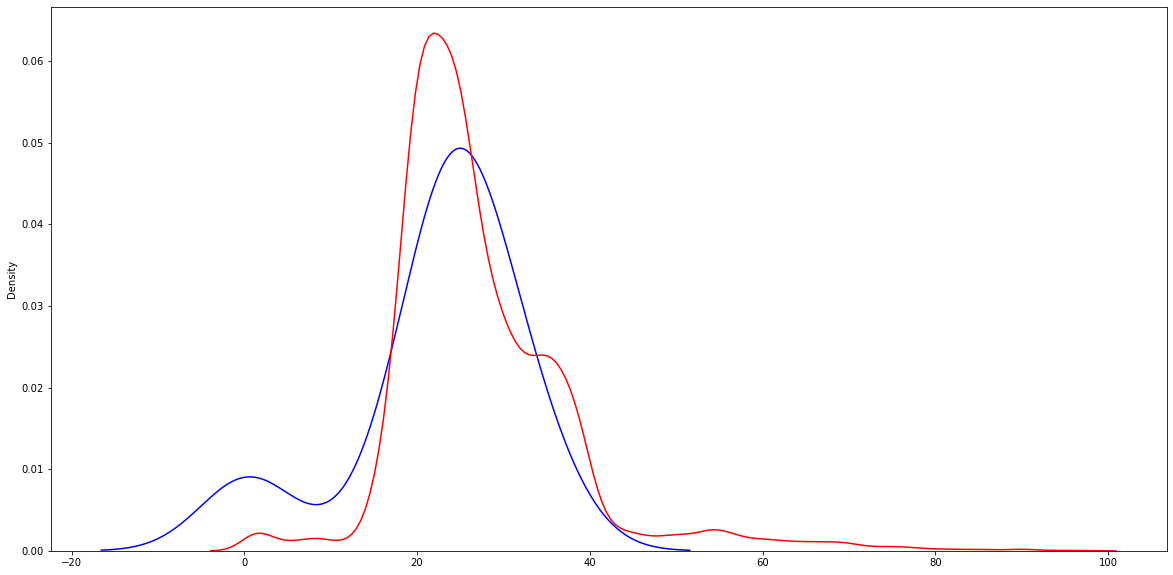

In [118]:
plt.figure(figsize=(20, 10))

#Prediction blue
#Label red

sns.kdeplot(pred, color = 'b' ,x = 'Age')
sns.kdeplot(gt, color = 'r',x = 'Age')

plt.show()

In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [133]:
print(accuracy_score(gt_gd, pred_gds))

0.8087


In [134]:
print(precision_score(gt_gd, pred_gds))

0.7898186889818689


In [135]:
print(recall_score(gt_gd, pred_gds))

0.9331026528258363
